In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from time import time

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearnex import patch_sklearn
patch_sklearn()

import warnings
warnings.filterwarnings("ignore")

from mltools import plot_data, plot_frontiere, make_grid, gen_arti

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# 1. DONNEES JOUET

In [11]:
def plot_frontiere_proba(data, f, step=20):
    grid, x, y = make_grid(data=data, step=step)
    plt.contourf(x, y, f(grid).reshape(x.shape), 255)
    
def plot_all(x, y, model):
    plt.figure()
    plot_frontiere_proba(x, lambda x: model.predict_proba(x)[:,0], step=50)
    plot_data(x,y)
    plt.show()
    
def test_and_plot_svm():
    kernels = ["linear", "rbf", "sigmoid", "poly"]
    data_types = [1,2]
    # data_eps = np.logspace(-3, -1, num=3)
    data_eps = [0.1]
    # data_types = [2]
    # kernels = ["rbf"]
    
    # generation de tt les types de donnes
    datax_tab = []
    datay_tab = []
    string_type = []
    string_eps = []
    for epsilon in data_eps:
        for data_type in data_types:
            datax, datay = gen_arti(nbex=3000, epsilon=epsilon, data_type=data_type)
            datax_tab.append(datax)
            datay_tab.append(datay)
            string_type.append(data_type)
            string_eps.append(epsilon)
            
    # generation de tout les types de svm
    for i in range(len(datax_tab)):
        X_train, X_test, Y_train, Y_test = train_test_split(datax_tab[i], datay_tab[i], test_size=0.2, shuffle=True)
        max_score = 0
        for ker in kernels:
            print("KERNEL:", ker, "DATA TYPE:", string_type[i], "DATA_EPSILON:", string_eps[i])
            parameters = {
                'C': np.logspace(-3, 2, 6),
                "gamma" : np.logspace(-3, 2, 6)
            }
            svm = GridSearchCV(SVC(max_iter=500,
                                    probability=True,
                                     kernel=ker),
                                   parameters, 
                                   scoring="accuracy",
                                   n_jobs=8, 
                                   cv=3,
                                   refit=True
                                   )
            svm.fit(X_train, Y_train)
            pred = svm.predict(X_test)
            acc = accuracy_score(pred, Y_test)
            print("ACCURACY:", acc)
            if acc > max_score:
                max_score = acc
                best_i = i
                best_svm = svm
                best_model_name = ker
            
        print("BEST C:", best_svm.best_params_)
        plot_all(datax_tab[best_i], datay_tab[best_i], best_svm) 
        plt.show()
        # fig, axes = plt.subplots(3, 1, figsize=(10, 15))
        # plot_learning_curve(
        #     best_svm, best_model_name, X_train, Y_train, axes=axes, cv=3, n_jobs=8
        # )
        # plt.show()

KERNEL: linear DATA TYPE: 1 DATA_EPSILON: 0.1
ACCURACY: 0.4666666666666667
KERNEL: rbf DATA TYPE: 1 DATA_EPSILON: 0.1
ACCURACY: 0.9983333333333333
KERNEL: sigmoid DATA TYPE: 1 DATA_EPSILON: 0.1
ACCURACY: 0.5533333333333333
KERNEL: poly DATA TYPE: 1 DATA_EPSILON: 0.1
ACCURACY: 0.515
BEST C: {'C': 100.0, 'gamma': 0.01}


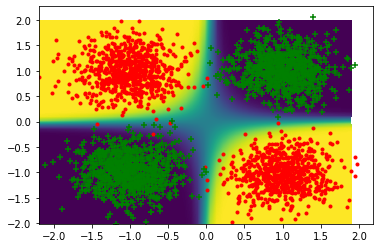

KERNEL: linear DATA TYPE: 2 DATA_EPSILON: 0.1
ACCURACY: 0.5333333333333333
KERNEL: rbf DATA TYPE: 2 DATA_EPSILON: 0.1
ACCURACY: 0.8466666666666667
KERNEL: sigmoid DATA TYPE: 2 DATA_EPSILON: 0.1
ACCURACY: 0.44666666666666666
KERNEL: poly DATA TYPE: 2 DATA_EPSILON: 0.1
ACCURACY: 0.485
BEST C: {'C': 0.1, 'gamma': 10.0}


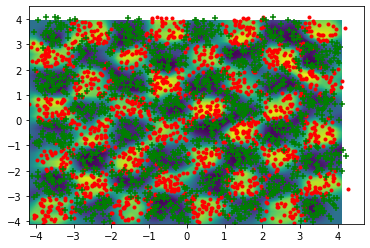

In [12]:
test_and_plot_svm()

In [5]:
# datax, datay = gen_arti(nbex=3000, epsilon=0.1, data_type=2)
# X_train, X_test, Y_train, Y_test = train_test_split(datax, datay, test_size=0.2, shuffle=True)


# svm = SVC(kernel="rbf", C=8, gamma=10, probability=True)
# svm.fit(X_train, Y_train)

# pred = svm.predict(X_test)
# print("ACCURACY:", accuracy_score(pred, Y_test))

# plot_all(datax, datay, svm) 
# plt.show()

# 2. DONNEES USPS

In [6]:
def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="viridis")

In [7]:
uspsdatatrain = "../TME4/data/USPS_train.txt"
uspsdatatest = "../TME4/data/USPS_test.txt"
alltrainx,alltrainy = load_usps(uspsdatatrain)
alltestx,alltesty = load_usps(uspsdatatest)
neg = 6
pos = 9
datax,datay = get_usps([neg,pos],alltrainx,alltrainy)
testx,testy = get_usps([neg,pos],alltestx,alltesty)

[6 6 6 ... 9 9 9]


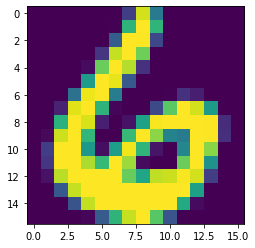

In [8]:
show_usps(datax[0])
print(datay)

In [9]:
def get_two_classes(neg, pos):
	datax,datay = get_usps([neg,pos],alltrainx,alltrainy)
	testx,testy = get_usps([neg,pos],alltestx,alltesty)
	datay = np.where(datay == neg, -1, 1)
	testy = np.where(testy == neg, -1, 1)
	return datax, datay, testx, testy

In [10]:
from itertools import combinations
for c1, c2 in combinations(range(10), 2):
    datax, datay, testx, testy = get_two_classes(c1, c2)
    